In [1]:
import requests
import time
import pandas as pd

In [ ]:
GIThub_token ="***************************"

In [ ]:
GITHUB_API_URL = "https://api.github.com"
SEARCH_USERS_URL = f"{GITHUB_API_URL}/search/users"
REPOS_URL = f"{GITHUB_API_URL}/users/{{}}/repos"

In [ ]:
HEADERS = {"Authorization": f"token {GIThub_token}"}

In [ ]:
QUERY = "location:Stockholm followers:>100"

In [ ]:
def get_stockholm_users():
    params = {'q': QUERY, 'per_page': 100, 'page': 1}
    users = []

    while True:
        response = requests.get(SEARCH_USERS_URL, headers=HEADERS, params=params)
        response_data = response.json()
        users.extend(response_data['items'])

        # Check if there are more pages to fetch
        if 'next' in response.links:
            params['page'] += 1
        else:
            break

        # Respect GitHub API rate limits
        time.sleep(1)

    return users

def clean_company_name(company):
    if company:
        return company.strip().lstrip('@').upper()
    return ''


def get_user_repos(username):
    repos = []
    params = {'per_page': 100, 'page': 1}

    while True:
        response = requests.get(REPOS_URL.format(username), headers=HEADERS, params=params)
        repos_data = response.json()

        repos.extend(repos_data)

        # Check if there are more pages to fetch
        if 'next' in response.links:
            params['page'] += 1
        else:
            break

        time.sleep(1)

    return repos


def write_users_to_csv(users):
  login=[]
  name=[]
  company=[]
  location=[]
  email=[]
  hireable=[]
  bio=[]
  public_repos=[]
  followers=[]
  following=[]
  created_at=[]
  for user in users:
    user=requests.get(user['url'],headers=HEADERS).json()
    login.append(user.get('login', ''))
    name.append(user.get('name', ''))
    company.append(clean_company_name(user.get('company', '')))
    location.append(user.get('location', ''))
    email.append(user.get('email', ''))
    hireable.append(user.get('hireable', ''))
    bio.append(user.get('bio', ''))
    public_repos.append(user.get('public_repos', 0))
    followers.append(user.get('followers', 0))
    following.append(user.get('following', 0))
    created_at.append(user.get('created_at', ''))
    time.sleep(1)
  df=pd.DataFrame({'login':login,'name':name,'company':company,'location':location,'email':email,'hireable':hireable,'bio':bio,'public_repos':public_repos,'followers':followers,'following':following,'created_at':created_at})
  return df

def get_latest_repos(user_repos_url):
    repos = []
    page = 1
    while True:
        # API call to fetch repositories with sorting by most recently pushed
        response = requests.get(user_repos_url, headers=HEADERS, params={'per_page': 100, 'page': page, 'sort': 'pushed', 'direction': 'desc'})
        user_repos = response.json()

        # Break if no more repositories
        if not user_repos:
            break

        repos.extend(user_repos)

        # If repos reach 500, stop
        if len(repos) >= 500:
            repos = repos[:500]  # Limit to 500 repositories
            break

        page += 1
        time.sleep(1)  # Sleep to respect rate limits

    return repos

def write_repos_to_csv(users):
  login=[]
  full_name=[]
  created_at=[]
  stargazers_count=[]
  watchers_count=[]
  language=[]
  has_projects=[]
  has_wiki=[]
  license_name=[]

  for user in users:
      user_repos_url = user['repos_url']
      user_repos = get_latest_repos(user_repos_url)
      for repo in user_repos:
        login.append(repo['owner']['login'])
        full_name.append(repo['full_name'] if repo['full_name'] else '')
        created_at.append(repo['created_at'] if repo['created_at'] else '')
        stargazers_count.append(repo['stargazers_count'] if repo['stargazers_count'] else '')
        watchers_count.append(repo['watchers_count'] if repo['watchers_count'] else '' )
        language.append(repo['language'] if repo['language'] else '' )
        has_projects.append(repo['has_projects'] if repo['has_projects'] else '')
        has_wiki.append(repo['has_wiki'] if repo['has_wiki'] else '')
        license_name.append(repo['license']['name'] if repo['license'] else '')
  df=pd.DataFrame({'login':login,'full_name':full_name,'created_at':created_at,'stargazers_count':stargazers_count,
                   'watchers_count':watchers_count,'language':language,'has_projects':has_projects,'has_wiki':has_wiki,
                   'license_name':license_name})
  return df


In [ ]:
users = get_stockholm_users()


In [ ]:
df= write_users_to_csv(users)
df.to_csv('users.csv', index=False)

In [ ]:
df1 = write_repos_to_csv(users)
df1.to_csv('repositories.csv', index=False)

# Read From Repo

In [11]:
import pandas as pd

In [12]:
users = pd.read_csv("https://raw.githubusercontent.com/gyanesh-iitmiimb/TDSProject1/refs/heads/main/users.csv")
repositories = pd.read_csv("https://raw.githubusercontent.com/gyanesh-iitmiimb/TDSProject1/refs/heads/main/repositories.csv")

In [13]:
users.head()

,Unnamed: 0.1,Unnamed: 0,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at
0,0,0,emmabostian,Emma Bostian,SPOTIFY,"Stockholm, Sweden",NaN,False,Front-end Software Engineer @ Spotify\r\n,61,6473,15,2014-05-22T17:47:40Z
1,1,1,emilk,Emil Ernerfeldt,"RERUN.IO, EGUI","Stockholm, Sweden",emil.ernerfeldt@gmail.com,False,"Rust coder, creator of egui, CTO of rerun.io",71,6267,20,2011-10-24T16:40:17Z
2,2,2,mpj,Mattias Petter Johansson,FUN FUN FUNCTION,"Stockholm, Sweden",NaN,True,NaN,142,5708,23,2008-07-22T10:20:27Z
3,3,3,hrydgard,Henrik Rydgård,NaN,"Stockholm, Sweden",hrydgard@gmail.com,False,NaN,60,5545,25,2009-09-24T18:40:26Z
4,4,4,eriklindernoren,Erik Linder-Norén,NaN,"Stockholm, Sweden",eriklindernoren@gmail.com,False,ML engineer at Apple. Excited about machine le...,24,5345,11,2014-06-24T16:31:53Z


In [14]:
repositories.head()

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,emmabostian,emmabostian/developer-portfolios,2019-09-13T14:18:58Z,7312.0,7312.0,NaN,True,True,NaN
1,emmabostian,emmabostian/emmabostian,2020-07-28T09:33:51Z,5.0,5.0,NaN,True,True,NaN
2,emmabostian,emmabostian/fem-css-foundations,2023-04-15T06:27:55Z,81.0,81.0,HTML,True,NaN,NaN
3,emmabostian,emmabostian/Front-End-FAQ,2018-11-01T07:47:51Z,694.0,694.0,NaN,True,True,Other
4,emmabostian,emmabostian/badass-conference-talks,2019-08-05T16:42:39Z,488.0,488.0,NaN,True,True,NaN


In [15]:
",".join(users.sort_values(by='followers',ascending=False)["login"][:5].tolist())

'emmabostian,emilk,mpj,hrydgard,eriklindernoren'

In [16]:
 users.created_at = pd.to_datetime(users.created_at)
 ",".join(users.sort_values(by='created_at',ascending=True)["login"][:5].tolist())

'Mange,kallepersson,fesplugas,etnt,pirelenito'

In [17]:
",".join(repositories.groupby('license_name').count()['full_name'].reset_index().sort_values(by='full_name',ascending=False)["license_name"][:3].tolist())

'MIT License,Apache License 2.0,Other'

In [18]:
users.groupby('company').count()['login'].reset_index().sort_values(by='login',ascending=False)["company"][:5].tolist()

['SPOTIFY', 'EMBARKSTUDIOS', 'GOOGLE', 'MOJANG', 'KLARNA']

In [19]:
repositories.groupby('language').count()['full_name'].reset_index().sort_values(by='full_name',ascending=False)["language"][:5].tolist()

['JavaScript', 'Python', 'Go', 'Java', 'TypeScript']

In [20]:
users_joined_after2020 = users[users['created_at'] > '2020-01-01']
users_list = users_joined_after2020['login'].tolist()

In [21]:
repositories[repositories['login'].isin(users_list)].groupby('language').count()['full_name'].reset_index().sort_values(by='full_name',ascending=False)["language"][:5].tolist()

['JavaScript', 'TypeScript', 'HTML', 'C#', 'Java']

In [22]:
repositories.groupby('language')['stargazers_count'].mean().reset_index().sort_values(by='stargazers_count',ascending=False)["language"][:5].tolist()

['RAML', 'jq', 'Mathematica', 'FreeBasic', 'MDX']

In [23]:
users['leader_strength'] = users['followers'] / (1 + users['following'])
top_5_leaders = users.sort_values('leader_strength', ascending=False).head(5)['login'].tolist()
",".join(top_5_leaders)

'spotify,Mojang,fornwall,joearms,EmbarkStudios'

In [24]:
users[["public_repos","followers"]].corr()

,public_repos,followers
public_repos,1.000000,0.033217
followers,0.033217,1.000000


In [25]:
import statsmodels.formula.api as sm

# Calculate the correlation between public_repos and followers
correlation = users[["public_repos", "followers"]].corr()

# Perform linear regression to estimate the relationship
model = sm.ols("followers ~ public_repos", data=users).fit()

# Print the regression results
print(model.summary())

# Extract the coefficient for public_repos, which represents the estimated increase in followers per additional repository
additional_followers_per_repo = model.params['public_repos']

print(f"\nEstimated additional followers per public repository: {additional_followers_per_repo:.2f}")

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4474
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.504
Time:                        03:12:07   Log-Likelihood:                -3272.6
No. Observations:                 407   AIC:                             6549.
Df Residuals:                     405   BIC:                             6557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      372.6574     47.576      7.833   

In [26]:
correl = repositories[["has_projects", "has_wiki"]]
correl['has_wiki'] = correl['has_wiki'].fillna(False).astype(bool)
correl['has_projects'] = correl['has_projects'].fillna(False).astype(bool)
correlation_projects_wiki = correl.corr()
correlation_projects_wiki

<ipython-input-26-30b42c03d436>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correl['has_wiki'] = correl['has_wiki'].fillna(False).astype(bool)
<ipython-input-26-30b42c03d436>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correl['has_wiki'] = correl['has_wiki'].fillna(False).astype(bool)
<ipython-input-26-30b42c03d436>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior,

,has_projects,has_wiki
has_projects,1.000000,0.374632
has_wiki,0.374632,1.000000


In [27]:
avg_following_hireable = users[users['hireable'] == True]['following'].mean()
avg_following_not_hireable = users[users['hireable'] != True]['following'].mean()
difference = avg_following_hireable - avg_following_not_hireable
print(f"{difference:.3f}")

48.674


In [28]:
users['bio_word_count'] = users['bio'].fillna('').apply(lambda x: len(x.split()) if x else 0)
users_with_bios = users[users['bio_word_count'] > 0]
model = sm.ols("followers ~ bio_word_count", data=users_with_bios).fit()
slope = model.params['bio_word_count']
print(f"{slope:.3f}")

6.553


In [29]:
repositories['created_at'] = pd.to_datetime(repositories['created_at'])
repositories['weekday'] = repositories['created_at'].dt.weekday
repositories['is_weekend'] = repositories['weekday'].apply(lambda x: x in [5, 6])  # 5: Saturday, 6: Sunday
weekend_repo_counts = repositories[repositories['is_weekend']].groupby('login')['full_name'].count().sort_values(ascending=False)
top_5_users = weekend_repo_counts.head(5).index.tolist()
",".join(top_5_users)

'HaraldNordgren,Nyholm,lydell,linhduongtuan,LinusU'

In [30]:
hireable_with_email = users[(users['hireable'] == True) & (users['email'].notna())].shape[0]
hireable_total = users[users['hireable'] == True].shape[0]
fraction_hireable_with_email = hireable_with_email / hireable_total if hireable_total > 0 else 0

not_hireable_with_email = users[(users['hireable'] != True) & (users['email'].notna())].shape[0]
not_hireable_total = users[users['hireable'] != True].shape[0]
fraction_not_hireable_with_email = not_hireable_with_email / not_hireable_total if not_hireable_total > 0 else 0

difference = fraction_hireable_with_email - fraction_not_hireable_with_email
print(f"{difference:.3f}")

0.176


In [31]:
surname_counts = {}
for name in users['name'].dropna():
  name_parts = name.strip().split()
  if name_parts:
    surname = name_parts[-1]
    surname_counts[surname] = surname_counts.get(surname, 0) + 1

max_count = 0
most_common_surnames = []
for surname, count in surname_counts.items():
  if count > max_count:
    max_count = count
    most_common_surnames = [surname]
  elif count == max_count:
    most_common_surnames.append(surname)

most_common_surnames.sort()
print(','.join(most_common_surnames))

Gustafsson,Persson


In [32]:
merged_dataset = repositories.merge(users, on='login', how='left')
merged_dataset.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
merged_dataset.rename(columns={'created_at_x':'repo_date','created_at_y':'user_date'},inplace=True)
merged_dataset.repo_date = pd.to_datetime(merged_dataset.repo_date)
merged_dataset.user_date = pd.to_datetime(merged_dataset.user_date)
merged_dataset.columns

Index(['login', 'full_name', 'repo_date', 'stargazers_count', 'watchers_count',
       'language', 'has_projects', 'has_wiki', 'license_name', 'weekday',
       'is_weekend', 'name', 'company', 'location', 'email', 'hireable', 'bio',
       'public_repos', 'followers', 'following', 'user_date',
       'leader_strength', 'bio_word_count'],
      dtype='object')

The most interesting and surprising fact you found after analyzing the the data


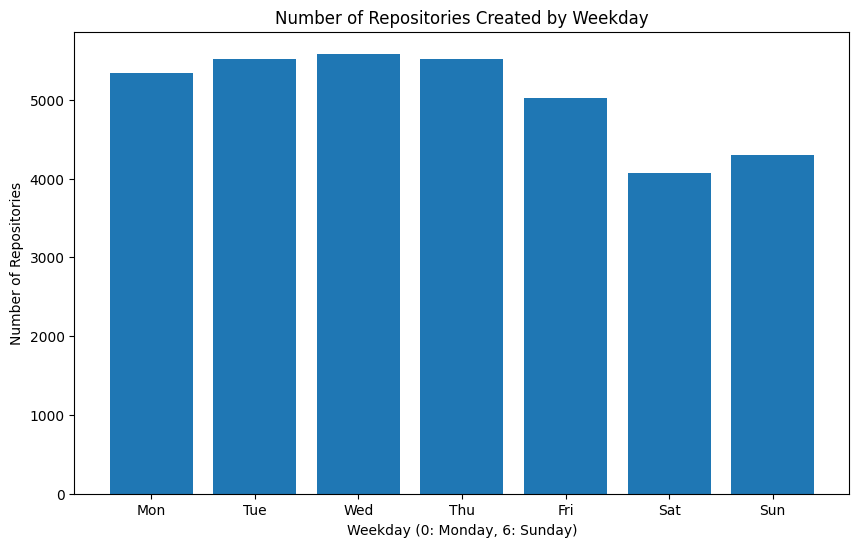

In [33]:
import matplotlib.pyplot as plt

# Assuming 'repositories' DataFrame is already loaded and 'repo_date' column is in datetime format
repositories['repo_date'] = pd.to_datetime(repositories['created_at'])
repositories['weekday'] = repositories['repo_date'].dt.dayofweek  # 0: Monday, 6: Sunday

# Group by weekday and count the number of repositories
weekday_repo_counts = repositories.groupby('weekday')['full_name'].count()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekday_repo_counts.index, weekday_repo_counts.values)
plt.xlabel('Weekday (0: Monday, 6: Sunday)')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories Created by Weekday')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

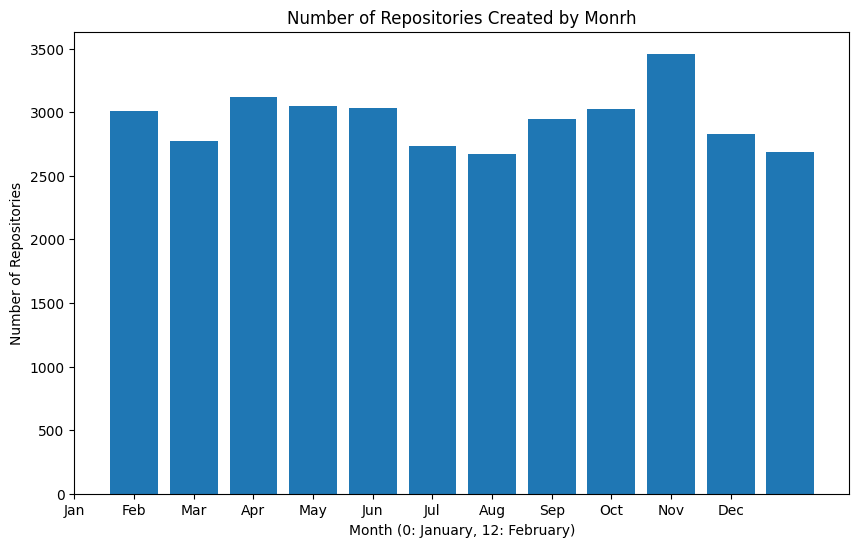

In [34]:
import matplotlib.pyplot as plt

# Assuming 'repositories' DataFrame is already loaded and 'repo_date' column is in datetime format
repositories['repo_date'] = pd.to_datetime(repositories['created_at'])
repositories['month'] = repositories['repo_date'].dt.month # 0: January, 12: February

# Group by weekday and count the number of repositories
weekday_repo_counts = repositories.groupby('month')['full_name'].count()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekday_repo_counts.index, weekday_repo_counts.values)
plt.xlabel('Month (0: January, 12: February)')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories Created by Monrh')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec'])
plt.show()

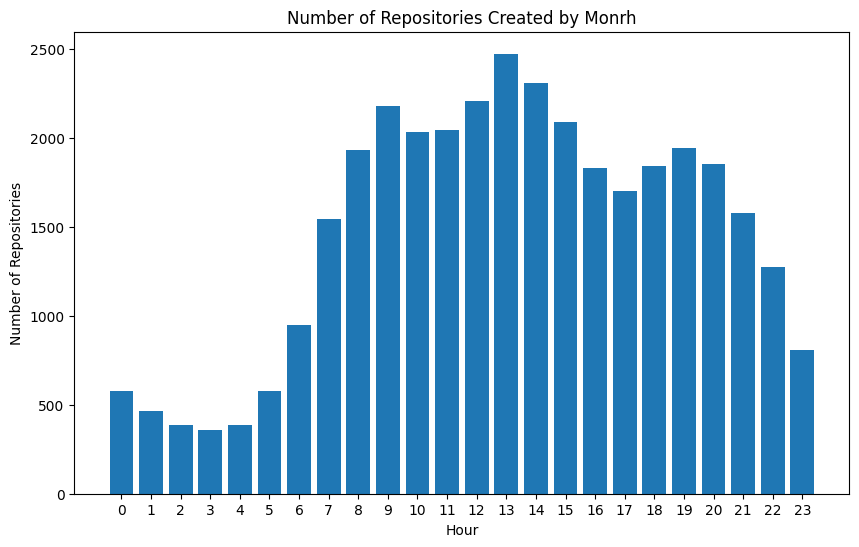

In [35]:
import matplotlib.pyplot as plt

# Assuming 'repositories' DataFrame is already loaded and 'repo_date' column is in datetime format
repositories['repo_date'] = pd.to_datetime(repositories['created_at'])
repositories['hour'] = repositories['repo_date'].dt.hour


# Group by weekday and count the number of repositories
weekday_repo_counts = repositories.groupby('hour')['full_name'].count()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekday_repo_counts.index, weekday_repo_counts.values)
plt.xlabel('Hour')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories Created by Monrh')
plt.xticks(range(24))
plt.show()

<ipython-input-36-f51892697416>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_category_counts = repositories.groupby('time_category')['full_name'].count()


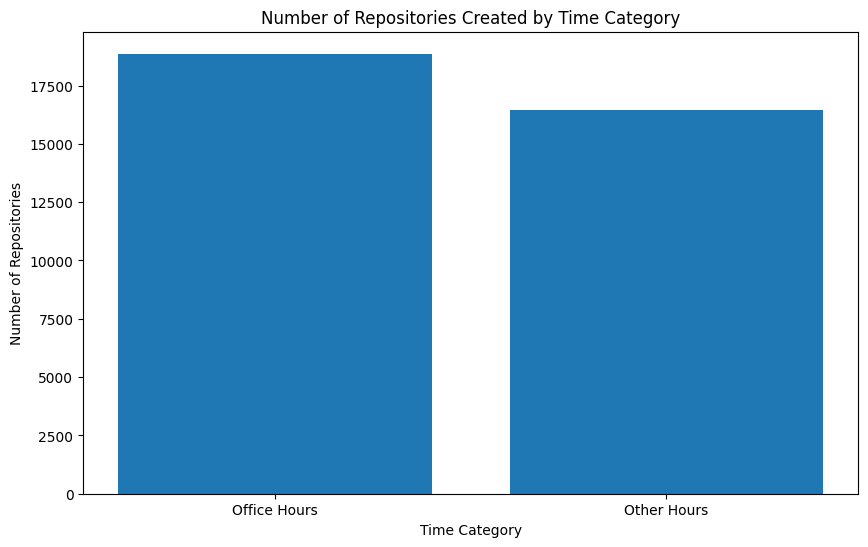

In [36]:
repositories['repo_date'] = pd.to_datetime(repositories['created_at'])
repositories['hour'] = repositories['repo_date'].dt.hour

bins = [-1, 8, 17, 24]  # -1 to include 0
labels = ['Other Hours', 'Office Hours', 'Other Hours']

# Use pd.cut to categorize hours, setting ordered=False to allow duplicate labels
repositories['time_category'] = pd.cut(repositories['hour'], bins=bins, labels=labels, include_lowest=True, ordered=False)

# Group by time category and count repositories
time_category_counts = repositories.groupby('time_category')['full_name'].count()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(time_category_counts.index, time_category_counts.values)
plt.xlabel('Time Category')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories Created by Time Category')
plt.show()

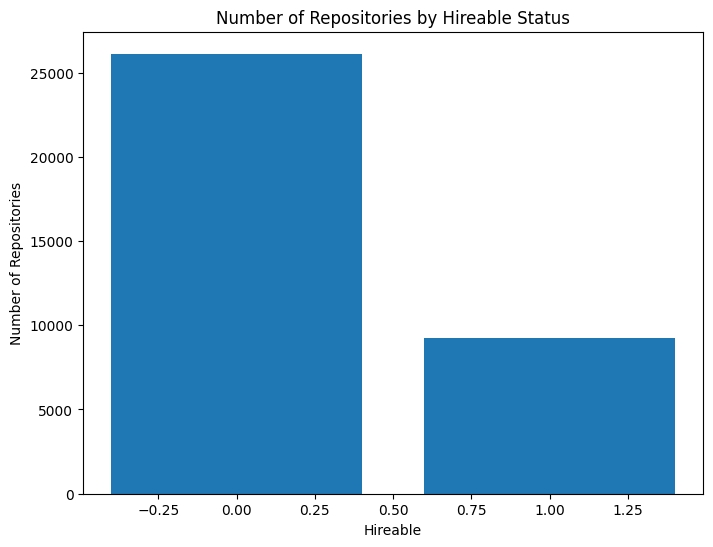

<ipython-input-37-21d0cc8ad517>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_category_hireable_counts = merged_dataset.groupby(['time_category', 'hireable'])['full_name'].count().unstack()


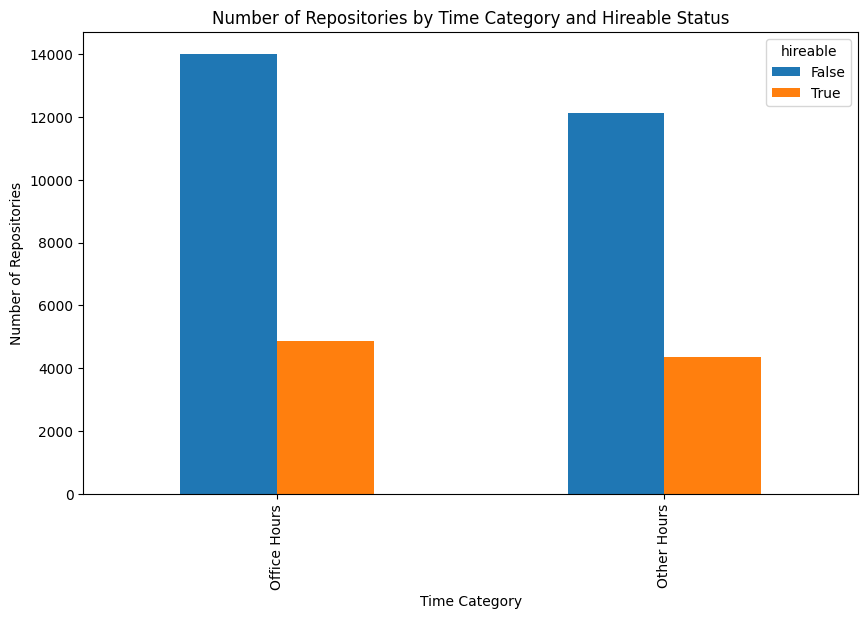

In [37]:

# Group by hireable status and count repositories
hireable_repo_counts = merged_dataset.groupby('hireable')['full_name'].count()

# Create a bar chart comparing repositories by hireable status
plt.figure(figsize=(8, 6))
plt.bar(hireable_repo_counts.index, hireable_repo_counts.values)
plt.xlabel('Hireable')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories by Hireable Status')
plt.show()
labels = ['Other Hours', 'Office Hours', 'Other Hours']

# Use pd.cut to categorize hours, setting ordered=False to allow duplicate labels
merged_dataset['hour'] = merged_dataset.repo_date.dt.hour
bins = [-1, 8, 17, 24]  # -1 to include 0

# Use pd.cut to categorize hours, setting ordered=False to allow duplicate labels
merged_dataset['time_category'] = pd.cut(merged_dataset['hour'], bins=bins, labels=labels, include_lowest=True, ordered=False)

# Group by time category and count repositories

time_category_hireable_counts = merged_dataset.groupby(['time_category', 'hireable'])['full_name'].count().unstack()

# Create a bar chart comparing repositories by time category and hireable status
time_category_hireable_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Time Category')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories by Time Category and Hireable Status')
plt.show()


An actionable recommendation for developers based on your analysis

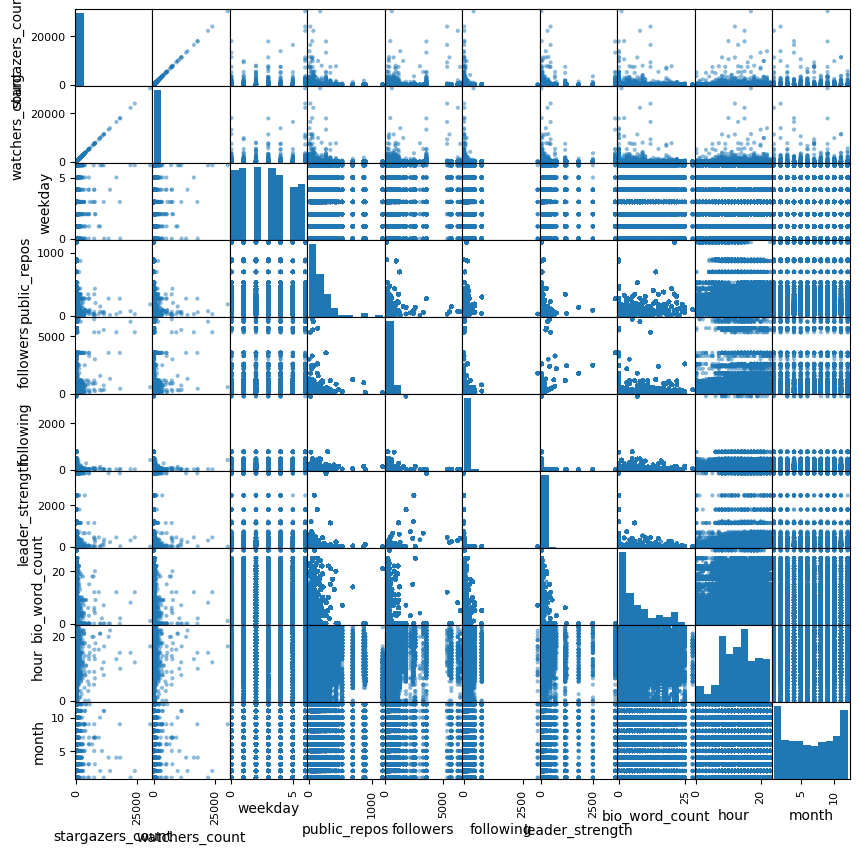

In [43]:
merged_dataset['weekday'] = merged_dataset.repo_date.dt.weekday
merged_dataset["month"] = merged_dataset.repo_date.dt.month
numeric_data = merged_dataset.select_dtypes(include=['number'])

# Create scatter matrix
pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10))
plt.show()

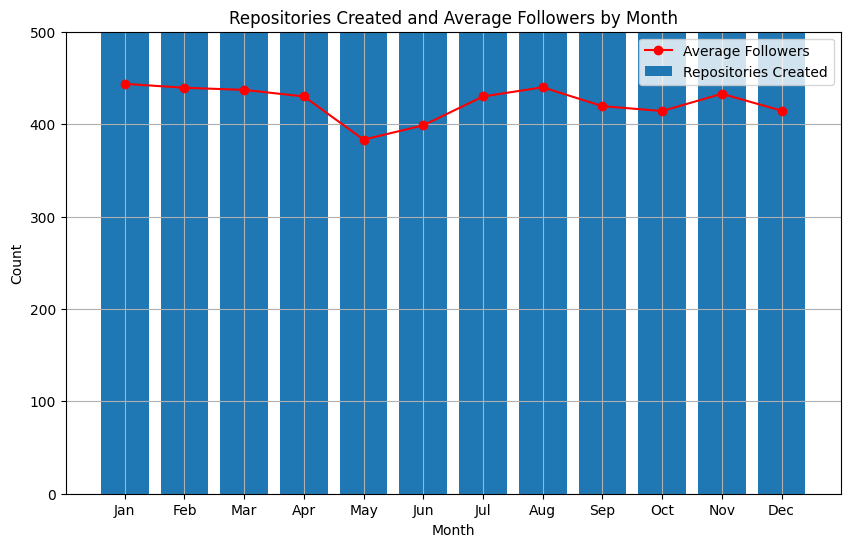

In [48]:
import matplotlib.pyplot as plt

# Group by month and count repositories
month_repo_counts = merged_dataset.groupby('month')['full_name'].count().reset_index()

# Group by month and get average followers
month_follower_counts = merged_dataset.groupby('month')['followers'].mean().reset_index()

# Merge the two DataFrames on 'month'
merged_counts = pd.merge(month_repo_counts, month_follower_counts, on='month')

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(merged_counts['month'], merged_counts['full_name'], label='Repositories Created')
plt.plot(merged_counts['month'], merged_counts['followers'], color='red', marker='o', label='Average Followers')

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Repositories Created and Average Followers by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.ylim((0,500))
# Show the plot
plt.show()

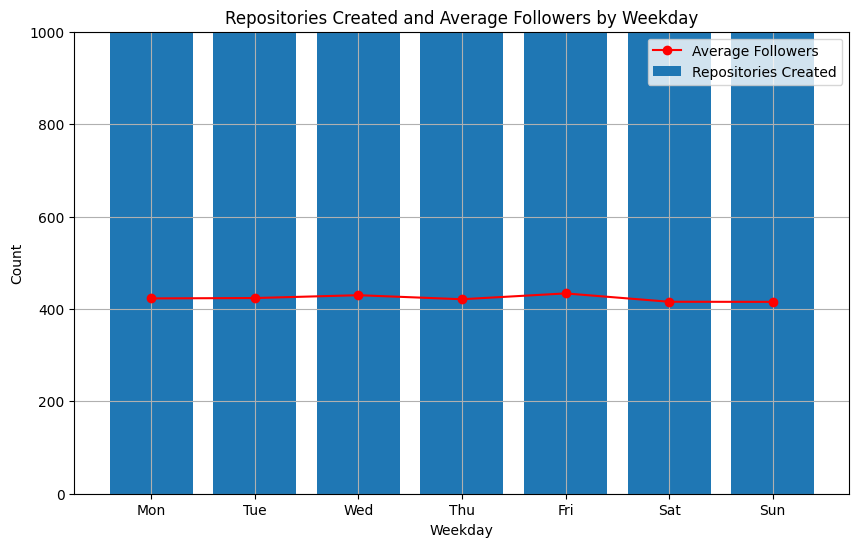

In [49]:
 import matplotlib.pyplot as plt

# Group by weekday and count repositories
weekday_repo_counts = merged_dataset.groupby('weekday')['full_name'].count().reset_index()

# Group by weekday and get average followers
weekday_follower_counts = merged_dataset.groupby('weekday')['followers'].mean().reset_index()

# Merge the two DataFrames on 'weekday'
merged_counts = pd.merge(weekday_repo_counts, weekday_follower_counts, on='weekday')

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(merged_counts['weekday'], merged_counts['full_name'], label='Repositories Created')
plt.plot(merged_counts['weekday'], merged_counts['followers'], color='red', marker='o', label='Average Followers')

# Customize the plot
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Repositories Created and Average Followers by Weekday')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set weekday labels
plt.legend()
plt.grid(True)
plt.ylim((0,1000))
# Show the plot
plt.show()

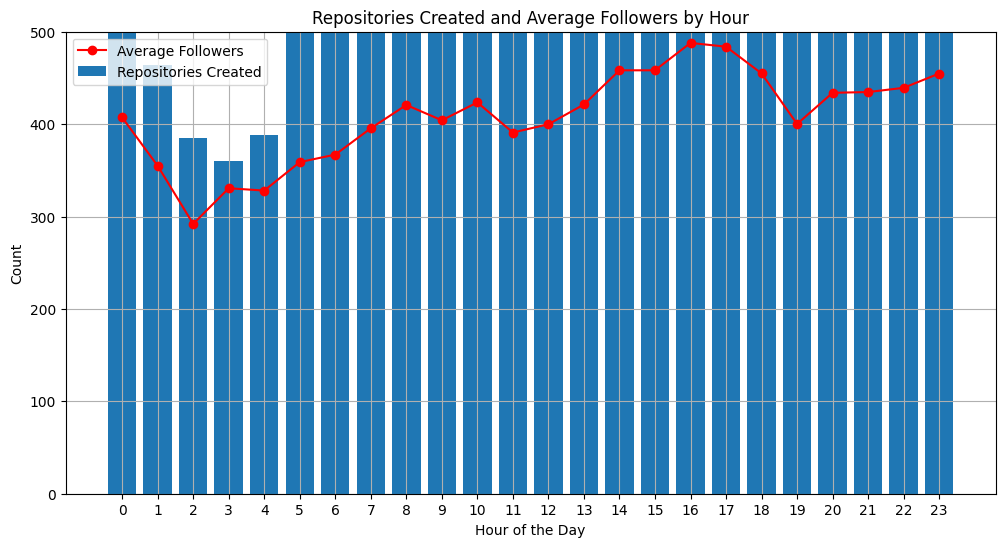

In [52]:
import matplotlib.pyplot as plt

# Group by hour and count repositories
hour_repo_counts = merged_dataset.groupby('hour')['full_name'].count().reset_index()

# Group by hour and get average followers
hour_follower_counts = merged_dataset.groupby('hour')['followers'].mean().reset_index()

# Merge the two DataFrames on 'hour'
merged_counts = pd.merge(hour_repo_counts, hour_follower_counts, on='hour')

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better visibility
plt.bar(merged_counts['hour'], merged_counts['full_name'], label='Repositories Created')
plt.plot(merged_counts['hour'], merged_counts['followers'], color='red', marker='o', label='Average Followers')

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Repositories Created and Average Followers by Hour')
plt.xticks(range(24))  # Set x-axis ticks for each hour
plt.legend()
plt.grid(True)
plt.ylim((0,500))
# Show the plot
plt.show()